**MSc Computational Physics AUTh**<br>
**Academic Year: 2024-2025**<br>
**Master's Thesis**<br>

**Thesis Title:**<br>  
# **"Reconstruction of the EoSs and classification of Exotic Stars using ML and ANNs models"**

**Implemented by: Ioannis Stergakis**<br>
**AEM: 4439**<br>

**Jupyter Notebook 1a**<br>
**Name: "polytrope_det_NS.ipynb"**<br>

**Description:**<br> 

**Abbrevations:**<br>
**1. NS -> Neutron Star**<br>

# 1. Preliminaries 

In [1]:
import numpy as np
import sympy as smp
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import random
from prettytable import PrettyTable

## **1.1 Defininition of constants and basic polytrope relations**

In [2]:
# Defining useful constants

ρ_sat = 2.7*10**14 # nuclear saturation density [g/cm^3]

c = 3e8 # vaccuum speed of light in m/s

MeV_to_J = 1.60218e-13 # 1MeV value in Joules

In [3]:
# Definition of useful symbols
ρ,Γi,Κi,P_im1,ρ_im1,E_im1 = smp.symbols("ρ,Γ_i,K_i,P_{i-1},ρ_{i-1},E_{i-1}")

In [4]:
# Converter of mass density from units g/cm^3 to MeV/fm^3 units
def conv_to_MeV(value):
    # Multiply by 10^3 to convert to SI units (kg/m^3)
    result = value*10**3
    # Multiply by c^2 to convert to J/m^3
    result = result*c**2
    # Divide by the MeV_to_J constant to convert to MeV/m^3
    result = result/MeV_to_J
    # Convert m to fm, for the units to be MeV/fm^3
    result = result*10**(-45)

    return result

In [5]:
# Defining the polytrope relation between pressure P and mass density ρ as a function
def P_poly(ρ,K,Γ):
    return K*ρ**Γ

# Defining the inverse polytrope relation between pressure P and mass density ρ as a function
def ρ_poly(P,K,Γ):
    return pow(P/K,1/Γ)

# Defining the K constant parameter as a function of pressure P and and mass density
def K_calc(P,ρ,Γ):
    return P/ρ**Γ

In [6]:
# Definition of the polytropic EOS

# Numerical definition
def EOS_polytrope(ρ,K_i,Γ_i,ρ_im1,P_im1,E_im1):
    if Γ_i!=1:
        result = (E_im1/ρ_im1 - P_im1/(ρ_im1*(Γ_i-1)))*ρ + K_i/(Γ_i-1)*ρ**Γ_i
    else:
        result = E_im1/ρ_im1*ρ + K_i*np.log(1/ρ_im1)*ρ-K_i*np.log(1/ρ)*ρ

    return result

# Numerical definition
def EOS_polytrope_alt(P,K_i,Γ_i,ρ_im1,P_im1,E_im1):
    if Γ_i!=1:
        result = (E_im1/ρ_im1 - P_im1/(ρ_im1*(Γ_i-1)))*pow(P/K_i,1/Γ_i) + P/(Γ_i-1)
    else:
        result = E_im1/ρ_im1*P/K_i + np.log(1/ρ_im1)*P - P*np.log(K_i/P)

    return result

# Symbolic definition
def EOS_polytrope_sym(ρ,K_i,Γ_i,ρ_im1,P_im1,E_im1):
    if Γ_i!=1:
        result = (E_im1/ρ_im1 - P_im1/(ρ_im1*(Γ_i-1)))*ρ + K_i/(Γ_i-1)*ρ**Γ_i
    else:
        result = E_im1/ρ_im1*ρ + K_i*smp.log(1/ρ_im1)*ρ-K_i*smp.log(1/ρ)*ρ

    return result        

In [7]:
EOS_polytrope_sym(ρ,Κi,1,ρ_im1,P_im1,E_im1)

E_{i-1}*ρ/ρ_{i-1} - K_i*ρ*log(1/ρ) + K_i*ρ*log(1/ρ_{i-1})

In [8]:
EOS_polytrope_sym(ρ,Κi,Γi,ρ_im1,P_im1,E_im1)

K_i*ρ**Γ_i/(Γ_i - 1) + ρ*(E_{i-1}/ρ_{i-1} - P_{i-1}/(ρ_{i-1}*(Γ_i - 1)))

In [9]:
EOS_polytrope(100,2,1,90,2,100)

132.18321424267629

In [10]:
P = P_poly(100,2,1)
EOS_polytrope_alt(P,2,1,90,2,100)

132.18321424267629

## **1.2 Definition of useful functions**

In [11]:
# Definition of the HLPS-1 and HLPS-3 EOSs
def HLPS_2(p):
    return 161.553+172.858*(1-np.exp(-p/22.8644))+2777.75*(1-np.exp(-p/1909.97))
def HLPS_3(p):
    return 81.5682+131.811*(1-np.exp(-p/4.41577))+924.143*(1-np.exp(-p/523.736))

In [12]:
# Function the returns n random selected values for Γ
def Γ_random_select(m,Γ_choices):
    Γ_select = random.choices(Γ_choices,k=m)
    return Γ_select        

In [13]:
# Function to return Γ codec value
def Γ_codec(Γ,Γ_choices):
    n = len(Γ_choices)
    for i in range(0,n):
        codec = chr(65+i)
        if Γ==Γ_choices[i]:
            break
    return codec

In [14]:
# Function to return the values of K_i, P_i and E_i given a
# starting pressure P_0, the bounds of the segments of 
# mass density ρ and the selected values of Γ for the segments of ρ
def poly_param_calc(P_0,E_0,ρ_bounds,Γ_selections,Γ_choices):
    # Definition of storage lists
    results = []
    Pi_vals = []
    Pi_vals.append(P_0)
    Ei_vals = []
    Ei_vals.append(E_0)
    Ei_vals_alt = []
    Ei_vals_alt.append(E_0)
    Γi_codec_values = []
    Ki_values = []
    
    # Number of segments
    n = len(Γ_selections)

    # For loop to calculate the values of Pi,Γi and Ki
    for i in range(0,n):
        Γi = Γ_selections[i]
        Γi_codec = Γ_codec(Γi,Γ_choices)
        Γi_codec_values.append(Γi_codec)

        Ki = K_calc(Pi_vals[i],ρ_bounds[i],Γi)
        Ki_values.append(Ki)

        Pi = P_poly(ρ_bounds[i+1],Ki,Γi)
        Pi_vals.append(Pi)

        Ei = EOS_polytrope(ρ_bounds[i+1],Ki,Γi,ρ_bounds[i],Pi_vals[i],Ei_vals[i])
        Ei_vals.append(Ei)

        Ei_alt = EOS_polytrope_alt(Pi_vals[i+1],Ki,Γi,ρ_bounds[i],Pi_vals[i],Ei_vals[i])
        Ei_vals_alt.append(Ei_alt)

    results = [Pi_vals,Ei_vals,Ei_vals_alt,Ki_values,Γi_codec_values]
    return results    


In [15]:
# Definition of the piecewise polytrope function of pressure vs mass density
def P_poly_piecewise(ρ,ρ_bounds,Ki_vals,Γi_vals):
    points = len(ρ_bounds)
    n = points-1

    conditions = []
    functions = []

    for i in range(0,n):
        conditions.append((ρ>=ρ_bounds[i])*(ρ<ρ_bounds[i+1]))
        functions.append(P_poly(ρ,Ki_vals[i],Γi_vals[i]))

    return np.piecewise(ρ,conditions,functions)   

In [16]:
# Definition of the piecewise polytrope function of pressure vs mass density
def E_poly_piecewise(ρ,ρ_bounds,Pi_vals,Ei_vals,Ki_vals,Γi_vals):
    points = len(ρ_bounds)
    n = points-1

    conditions = []
    functions = []

    for i in range(0,n):
        conditions.append((ρ>=ρ_bounds[i])*(ρ<ρ_bounds[i+1]))
        functions.append(EOS_polytrope(ρ,Ki_vals[i],Γi_vals[i],ρ_bounds[i],Pi_vals[i],Ei_vals[i]))

    return np.piecewise(ρ,conditions,functions)   

In [17]:
# Definition of the piecewise polytrope function of pressure vs mass density
def E_poly_piecewise_alt(P,ρ_bounds,Pi_vals,Ei_vals,Ki_vals,Γi_vals):
    points = len(ρ_bounds)
    n = points-1

    conditions = []
    functions = []

    for i in range(0,n):
        conditions.append((P>=Pi_vals[i])*(P<Pi_vals[i+1]))
        functions.append(EOS_polytrope_alt(P,Ki_vals[i],Γi_vals[i],ρ_bounds[i],Pi_vals[i],Ei_vals[i]))

    return np.piecewise(P,conditions,functions)   

In [18]:
# Define a function that plots the grid of the polytrope EOS

def grid_poly(ρ_0,ρ_n,n,P_0,E_0,Γ_choices):
    # Calculating the bounds of the mass density ρ segments
    log_ρ0 = np.log(ρ_0)
    log_ρn = np.log(ρ_n)
    ρ_seg_bounds = np.exp(np.linspace(log_ρ0,log_ρn,n+1))
    
    # Find the total number of possible EOS to be produced
    choices = len(Γ_choices)
    total_EOS = choices**n
    
    print("PLOTTIND THE GRID OF POLYTROPE EOS")
    print("----------------------------------------------")
    print("Γ choices: ",Γ_choices)
    print("Number of Γ possible choices: choices=%d"%len(Γ_choices))
    print("Number of mass density segments: n=%d"%n)
    print("Total EOSs to be produced (choices^n): %d"%total_EOS)
    print("----------------------------------------------")
    
    # Definition of the figure of the polytrope EOSs grid
    fig_grid_P,axis_grid_P = plt.subplots(1,1)
    fig_grid_E,axis_grid_E = plt.subplots(1,1)
    m=1000
    ρ_range = np.linspace(ρ_0,ρ_n,m)

    i = 1
    Γ_selections = []
    Γ_selection = Γ_random_select(n,Γ_choices)
    Γ_selections.append(Γ_selection)
    results = poly_param_calc(P_0,E_0,ρ_seg_bounds,Γ_selection,Γ_choices)
    Pi_vals = results[0]
    Ei_vals = results[1]
    Ki_vals = results[3]
    #print(Ki_vals)
    P_range = []
    E_range = []
    E_range_alt = []
    for j in range(0,m):
        P = P_poly_piecewise(ρ_range[j],ρ_seg_bounds,Ki_vals,Γ_selection)
        P_range.append(P)
        Enrg = E_poly_piecewise(ρ_range[j],ρ_seg_bounds,Pi_vals,Ei_vals,Ki_vals,Γ_selection)
        E_range.append(Enrg)
        Enrg_alt = E_poly_piecewise_alt(P,ρ_seg_bounds,Pi_vals,Ei_vals,Ki_vals,Γ_selection)
        E_range_alt.append(Enrg_alt)
    axis_grid_P.plot(ρ_range,P_range,lw=1.2,color="cornflowerblue")
    axis_grid_E.plot(P_range,E_range,lw=1.2)
    axis_grid_E.plot(P_range,E_range_alt,"--",lw=0.8,color="indianred")    
    
    while i<=total_EOS:
        Γ_selection = Γ_random_select(n,Γ_choices)
        if Γ_selections.count(Γ_selection)!=0:
            continue
        else:
            results = poly_param_calc(P_0,E_0,ρ_seg_bounds,Γ_selection,Γ_choices)
            Pi_vals = results[0]
            Ei_vals = results[1]
            Ki_vals = results[3]
            #print(Ki_vals)
            P_range = []
            E_range = []
            E_range_alt = []
            for j in range(0,m):
                P = P_poly_piecewise(ρ_range[j],ρ_seg_bounds,Ki_vals,Γ_selection)
                P_range.append(P)
                Enrg = E_poly_piecewise(ρ_range[j],ρ_seg_bounds,Pi_vals,Ei_vals,Ki_vals,Γ_selection)
                E_range.append(Enrg)
                Enrg_alt = E_poly_piecewise_alt(P,ρ_seg_bounds,Pi_vals,Ei_vals,Ki_vals,Γ_selection)
                E_range_alt.append(Enrg_alt)
            clr = "cornflowerblue"
            clr2 = "indianred"    
            if i==total_EOS:
                clr = "black"
                clr2 = "black"    
            axis_grid_P.plot(ρ_range,P_range,lw=1.2,color=clr)
            axis_grid_E.plot(P_range,E_range,lw=1.2,color=clr)
            axis_grid_E.plot(P_range,E_range_alt,"--",lw=0.8,color=clr2)

            i = i+1
    
    axis_grid_P.set_xlabel(r"Mass density $\rho c^2$ $[MeV*fm^{-3}]$")
    axis_grid_P.set_ylabel(r"Pressure $P$ $[MeV*fm^{-3}]$")
    axis_grid_P.set_xscale("log")
    axis_grid_P.set_yscale("log")
    fig_grid_P.show()

    axis_grid_E.set_xlabel(r"Pressure $P$ $[MeV*fm^{-3}]$")
    axis_grid_E.set_ylabel(r"Energy density $e$ $[MeV*fm^{-3}]$")
    axis_grid_E.set_xscale("log")
    axis_grid_E.set_yscale("log")
    fig_grid_E.show()


## **1.3 Determining the starting pressure of the polytrope behavior**

In [19]:
conv_to_MeV(5*ρ_sat)

758.3417593528818

In [20]:
# Defining a function to plot the known pressure vs mass density scatter data
def plot_EOS_data(ρ,P,EOS_name,axis):
    return axis.plot(ρ,P,".",ms=10,label=f"{EOS_name}")

In [21]:
# HLPS-1 and HLPS-3 scatter data in MeV/fm^3 units

# Mass density ρ*c^2 scatter data 
ρ_scatter = [87.07,107.1,118.1,129.9,142.5,155.9,165.3]

# Pressure P scatter data
P_scatter_HLPS2 = [0.4470,0.7162,0.9094,1.154,1.464,1.851,2.163]
P_scatter_HLPS3 = [0.6960,1.150,1.473,1.880,2.392,3.028,3.542]

C:\Users\johns\AppData\Local\Temp\ipykernel_26444\3072927463.py:40: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_interpld.show()


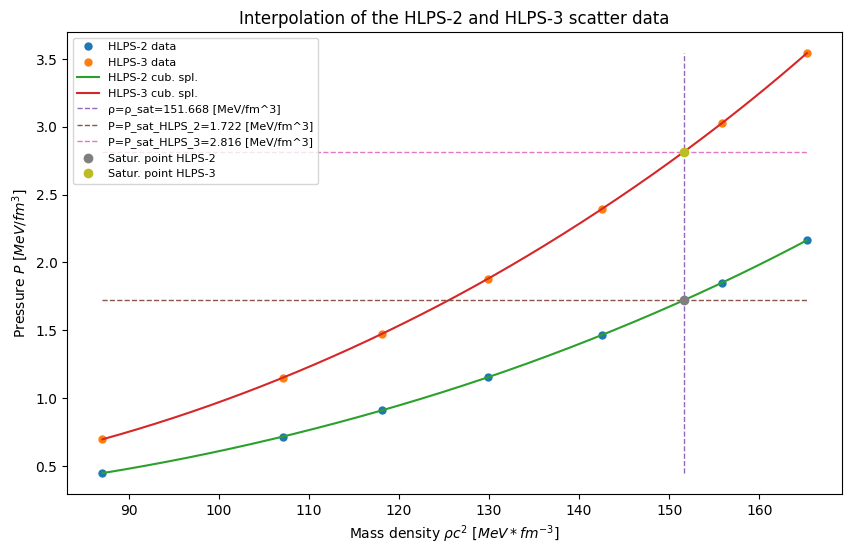

In [22]:
fig_interpld,axis_interpld = plt.subplots(1,1,figsize=(10,6))
# Calculating the cubic splines for the HLPS-1 and HLPS-3 scatter
spl_HLPS_1 = CubicSpline(ρ_scatter,P_scatter_HLPS2)
spl_HLPS_3 = CubicSpline(ρ_scatter,P_scatter_HLPS3)

# Defining a range of mass density values
ρ_range = np.linspace(ρ_scatter[0],ρ_scatter[-1],200)

# Plotting the scatter data of the HLPS-1 and HLPS-3 EOSs
plot_EOS_data(ρ_scatter,P_scatter_HLPS2,"HLPS-2 data",axis_interpld)
plot_EOS_data(ρ_scatter,P_scatter_HLPS3,"HLPS-3 data",axis_interpld)

# Plotting the respective cubic splines for the scatter data of HLPS-1 and HLPS-3
axis_interpld.plot(ρ_range,spl_HLPS_1(ρ_range),label="HLPS-2 cub. spl.")
axis_interpld.plot(ρ_range,spl_HLPS_3(ρ_range),label="HLPS-3 cub. spl.")

# Plotting the ρ=ρ_sat line
ρ_sat_MeV = conv_to_MeV(ρ_sat)
x = [ρ_sat_MeV,ρ_sat_MeV]
y = [min(P_scatter_HLPS2[0],P_scatter_HLPS3[0]),max(P_scatter_HLPS2[-1],P_scatter_HLPS3[-1])]
axis_interpld.plot(x,y,"--",lw=1,label="ρ=ρ_sat=%.3f [MeV/fm^3]"%ρ_sat_MeV)

# Finding and plotting the Pressure at the nuclear saturation density ρ_sat
P_saturation_HLPS_2 = spl_HLPS_1(ρ_sat_MeV)
P_saturation_HLPS_3 = spl_HLPS_3(ρ_sat_MeV)

x = [ρ_scatter[0],ρ_scatter[-1]]
y1 = [P_saturation_HLPS_2,P_saturation_HLPS_2]
y2 = [P_saturation_HLPS_3,P_saturation_HLPS_3]
axis_interpld.plot(x,y1,"--",lw=1,label="P=P_sat_HLPS_2=%.3f [MeV/fm^3]"%P_saturation_HLPS_2)
axis_interpld.plot(x,y2,"--",lw=1,label="P=P_sat_HLPS_3=%.3f [MeV/fm^3]"%P_saturation_HLPS_3)

axis_interpld.plot(ρ_sat_MeV,P_saturation_HLPS_2,".",ms=12,label="Satur. point HLPS-2")
axis_interpld.plot(ρ_sat_MeV,P_saturation_HLPS_3,".",ms=12,label="Satur. point HLPS-3")

axis_interpld.set_xlabel(r"Mass density $\rho c^2$ $[MeV*fm^{-3}]$")
axis_interpld.set_ylabel(r"Pressure $P$ $[MeV/fm^3]$")
axis_interpld.set_title("Interpolation of the HLPS-2 and HLPS-3 scatter data")
axis_interpld.legend(fontsize=8,loc=2)
fig_interpld.show()

# 2. Results 

## **2.1 Displaying polytrope grid graphs for the HLPS-1 EOS**

PLOTTIND THE GRID OF POLYTROPE EOS
----------------------------------------------
Γ choices:  [1, 4]
Number of Γ possible choices: choices=2
Number of mass density segments: n=8
Total EOSs to be produced (choices^n): 256
----------------------------------------------


C:\Users\johns\AppData\Local\Temp\ipykernel_26444\3115042588.py:85: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_grid_P.show()
C:\Users\johns\AppData\Local\Temp\ipykernel_26444\3115042588.py:91: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_grid_E.show()


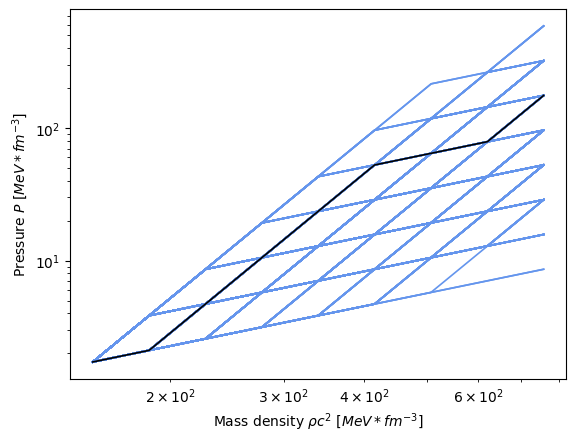

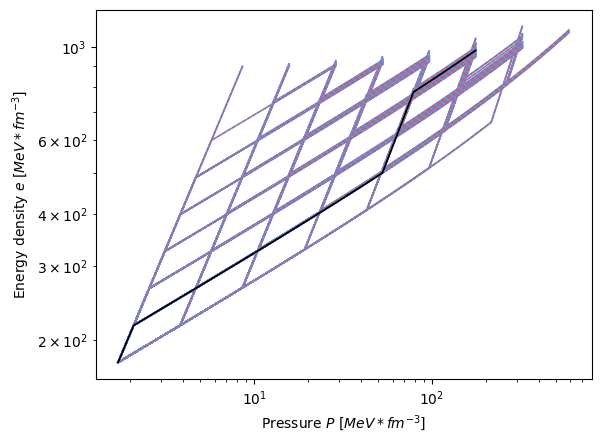

In [23]:
ρ_sat_x8_MeV = 5*ρ_sat_MeV
grid_poly(ρ_sat_MeV,ρ_sat_x8_MeV,8,P_saturation_HLPS_2,HLPS_2(P_saturation_HLPS_2),[1,4])

PLOTTIND THE GRID OF POLYTROPE EOS
----------------------------------------------
Γ choices:  [1, 2, 3, 4]
Number of Γ possible choices: choices=4
Number of mass density segments: n=4
Total EOSs to be produced (choices^n): 256
----------------------------------------------


C:\Users\johns\AppData\Local\Temp\ipykernel_26444\3115042588.py:85: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_grid_P.show()
C:\Users\johns\AppData\Local\Temp\ipykernel_26444\3115042588.py:91: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_grid_E.show()


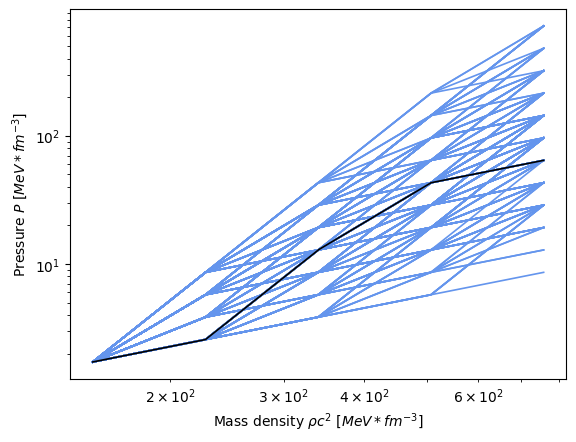

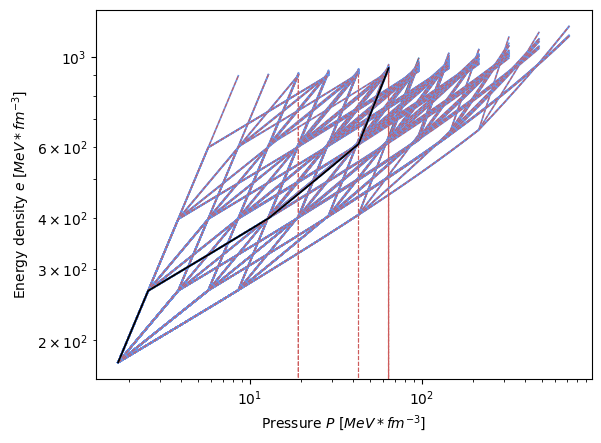

In [24]:
ρ_sat_x8_MeV = 5*ρ_sat_MeV
grid_poly(ρ_sat_MeV,ρ_sat_x8_MeV,4,P_saturation_HLPS_2,HLPS_2(P_saturation_HLPS_2),[1,2,3,4])

## **2.2 Displaying polytrope grid graphs for the HLPS-3 EOS**

PLOTTIND THE GRID OF POLYTROPE EOS
----------------------------------------------
Γ choices:  [1, 4]
Number of Γ possible choices: choices=2
Number of mass density segments: n=8
Total EOSs to be produced (choices^n): 256
----------------------------------------------


C:\Users\johns\AppData\Local\Temp\ipykernel_26444\3115042588.py:85: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_grid_P.show()
C:\Users\johns\AppData\Local\Temp\ipykernel_26444\3115042588.py:91: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_grid_E.show()


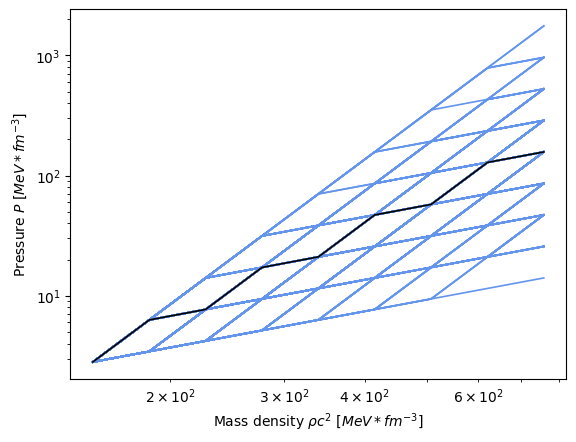

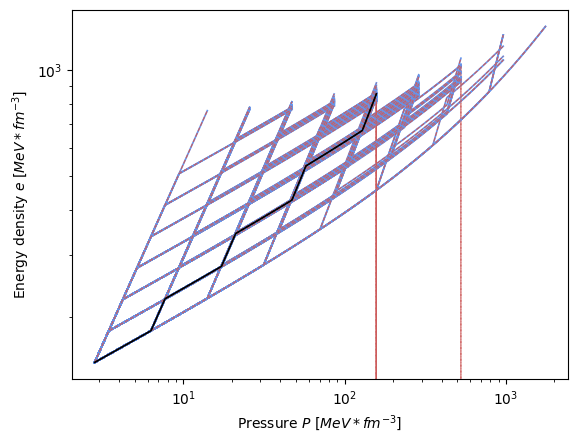

In [25]:
ρ_sat_x8_MeV = 5*ρ_sat_MeV
grid_poly(ρ_sat_MeV,ρ_sat_x8_MeV,8,P_saturation_HLPS_3,HLPS_3(P_saturation_HLPS_3),[1,4])

PLOTTIND THE GRID OF POLYTROPE EOS
----------------------------------------------
Γ choices:  [1, 2, 3, 4]
Number of Γ possible choices: choices=4
Number of mass density segments: n=4
Total EOSs to be produced (choices^n): 256
----------------------------------------------


C:\Users\johns\AppData\Local\Temp\ipykernel_26444\3115042588.py:85: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_grid_P.show()
C:\Users\johns\AppData\Local\Temp\ipykernel_26444\3115042588.py:91: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_grid_E.show()


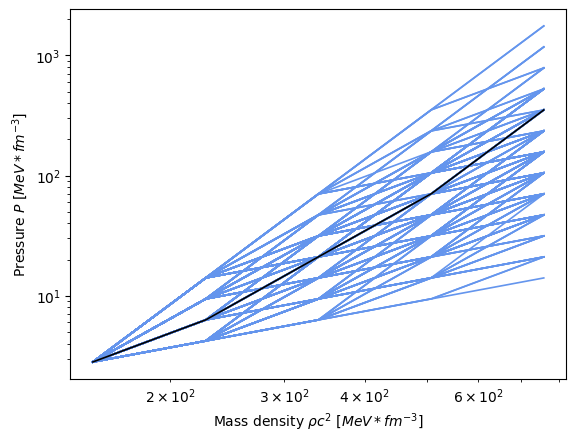

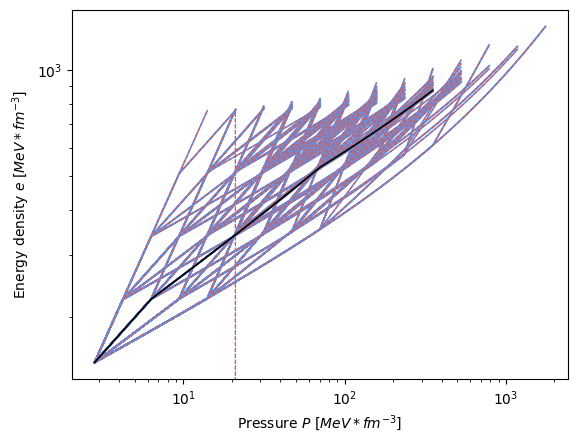

In [26]:
grid_poly(ρ_sat_MeV,ρ_sat_x8_MeV,4,P_saturation_HLPS_3,HLPS_3(P_saturation_HLPS_3),[1,2,3,4])